## Goal:
Generate nba career predictions data based on our first model's results. Run this notebook in the `tensorflow` container.

Note: We have issues with imblearn being installed in-line, so please run `pip install imblearn` in a terminal window and restart the kernel.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import itertools
from sklearn.preprocessing import scale, LabelEncoder, LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
from imblearn.over_sampling import SMOTE
import joblib as jb
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)
sns.set_style('whitegrid')
sns.set(rc = {'figure.figsize':(12, 8)})

Read in our input data. This data contains NCAA basketball players' biometrics and game play data. This numerical data has been partitioned into bins in order to reinforce patterns to our model. 

In [2]:
data = pd.read_csv('../Data/historical_binned.csv')
data.drop_duplicates(subset = ['ncaa_id'], inplace = True)
print(data.shape)
data.head()

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(18753, 406)


,ncaa_id,player_name,nba_career_quality,made_nba,field_goals_bin_1,field_goals_bin_2,field_goals_bin_3,field_goals_bin_4,three_point_attempt_rate_bin_1,three_point_attempt_rate_bin_2,three_point_attempt_rate_bin_3,defensive_win_shares_bin_1,defensive_win_shares_bin_2,defensive_win_shares_bin_3,defensive_win_shares_bin_4,blocks_bin_1,blocks_bin_2,blocks_bin_3,blocks_bin_4,blocks_bin_5,games_played_bin_1,games_played_bin_2,games_played_bin_3,turnovers_bin_1,turnovers_bin_2,turnovers_bin_3,turnovers_bin_4,turnover_percentage_bin_1,turnover_percentage_bin_2,turnover_percentage_bin_3,total_rebounds_bin_1,total_rebounds_bin_2,total_rebounds_bin_3,total_rebounds_bin_4,three_pointers_bin_1,three_pointers_bin_2,three_pointers_bin_3,three_pointers_bin_4,games_started_bin_1,games_started_bin_2,games_started_bin_3,games_started_bin_4,three_point_percentage_bin_1,three_point_percentage_bin_2,three_point_percentage_bin_3,three_point_percentage_bin_4,offensive_win_shares_bin_1,offensive_win_shares_bin_2,offensive_win_shares_bin_3,weight_bin_1,weight_bin_2,weight_bin_3,weight_bin_4,weight_bin_5,free_throw_percentage_bin_1,free_throw_percentage_bin_2,free_throw_percentage_bin_3,two_pointers_bin_1,two_pointers_bin_2,two_pointers_bin_3,two_pointers_bin_4,high_school_national_rank_bin_1,high_school_national_rank_bin_2,defensive_rebounds_bin_1,defensive_rebounds_bin_2,defensive_rebounds_bin_3,defensive_rebounds_bin_4,free_throw_attempts_bin_1,free_throw_attempts_bin_2,free_throw_attempts_bin_3,free_throw_attempts_bin_4,field_goal_percentage_bin_1,field_goal_percentage_bin_2,field_goal_percentage_bin_3,field_goal_percentage_bin_4,field_goal_percentage_bin_5,two_point_attempts_bin_1,two_point_attempts_bin_2,two_point_attempts_bin_3,two_point_attempts_bin_4,field_goal_attempts_bin_1,field_goal_attempts_bin_2,field_goal_attempts_bin_3,field_goal_attempts_bin_4,two_point_percentage_bin_1,two_point_percentage_bin_2,two_point_percentage_bin_3,two_point_percentage_bin_4,steals_bin_1,steals_bin_2,steals_bin_3,steals_bin_4,free_throw_attempt_rate_bin_1,free_throw_attempt_rate_bin_2,free_throw_attempt_rate_bin_3,free_throw_attempt_rate_bin_4,free_throw_attempt_rate_bin_5,free_throw_attempt_rate_bin_6,points_bin_1,points_bin_2,points_bin_3,points_bin_4,usage_percentage_bin_1,usage_percentage_bin_2,usage_percentage_bin_3,three_point_attempts_bin_1,three_point_attempts_bin_2,three_point_attempts_bin_3,three_point_attempts_bin_4,offensive_rebounds_bin_1,offensive_rebounds_bin_2,offensive_rebounds_bin_3,offensive_rebounds_bin_4,high_school_recruit_score_bin_2,high_school_recruit_score_bin_3,high_school_recruit_score_bin_4,high_school_recruit_score_bin_5,high_school_recruit_score_bin_6,draft_rank_bin_1,draft_rank_bin_2,draft_rank_bin_3,draft_rank_bin_4,draft_rank_bin_5,assists_bin_1,assists_bin_2,assists_bin_3,assists_bin_4,personal_fouls_bin_1,personal_fouls_bin_2,personal_fouls_bin_3,personal_fouls_bin_4,assist_percentage_bin_1,assist_percentage_bin_2,assist_percentage_bin_3,assist_percentage_bin_4,minutes_played_bin_1,minutes_played_bin_2,minutes_played_bin_3,minutes_played_bin_4,height_bin_1,height_bin_2,height_bin_3,height_bin_4,height_bin_5,made_nba_bin_1,made_nba_bin_2,height_to_weight_bin_1,height_to_weight_bin_2,height_to_weight_bin_3,height_to_weight_bin_4,height_to_weight_bin_6,weight_to_height_bin_1,weight_to_height_bin_2,weight_to_height_bin_3,weight_to_height_bin_4,weight_to_height_bin_5,weight_to_height_bin_6,recruit_draft_rank_mean_bin_1,recruit_draft_rank_mean_bin_2,draft_recruit_ratio_bin_1,draft_recruit_ratio_bin_2,draft_recruit_ratio_bin_3,draft_recruit_ratio_bin_4,assist_to_turnover_ratio_bin_1,assist_to_turnover_ratio_bin_2,assist_to_turnover_ratio_bin_3,assist_to_turnover_ratio_bin_4,assist_to_turnover_ratio_bin_5,assist_to_turnover_ratio_bin_6,assists_per_minute_bin_1,assists_per_minute_bin_2,assists_per_minute_bin_3,assists_per_minute_bin_4,assists_per_minute_bin_5,assists_per_minute_bin_6,blocks_per_minute_bin_1,blocks_per_minute_bin_2,bl

Load up the first model and the features to input.

In [3]:
first_features = jb.load('../Models/nba_model_kbest.pkl')
first_model = jb.load('../Models/nba_model.pkl')

In [4]:
features = data.columns.values[first_features.get_support(True)]
features

array(['offensive_rebounds_bin_4', 'high_school_recruit_score_bin_3',
       'high_school_recruit_score_bin_4', 'draft_rank_bin_1',
       'height_bin_2', 'height_bin_3', 'win_shares_per_minute_bin_4',
       'usage_percentage', 'personal_fouls', 'height'], dtype=object)

Store the first model predictions in the `nba_pred` column

In [5]:
data['nba_pred'] = [x[1] for x in first_model.predict_proba(data[features])]

We would expect the NBA draft probabilities to have this distribution as most NCAA players are not at the caliber needed to be drafted into the NBA.

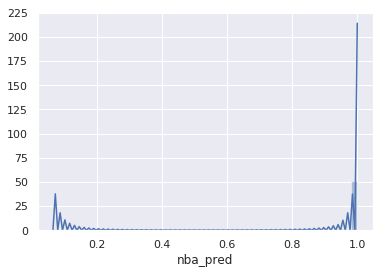

In [6]:
sns.distplot(data.nba_pred);

Set a probability threshold on players we deem would make it to the NBA

In [7]:
mask = (data.nba_pred >= 0.5).values

Those who do not have an NBA role in the `role` column means they did not make it to the NBA

In [8]:
data.nba_career_quality.fillna('Non-NBA', inplace = True)

Transform the roles into numeric labels for model processing

In [9]:
data['role_numeric'] = np.argmax(LabelBinarizer().fit_transform(data.nba_career_quality), axis = 1)

In [10]:
roles_dict = {}
for i in data.sort_values(by = 'role_numeric').role_numeric.unique():
    r = data.loc[data.role_numeric == i].nba_career_quality.unique()[0]
    rd = {i : r}
    roles_dict.update(rd)

Here are the different numerical labels corresponding to our NBA career success levels

In [11]:
roles_dict

{0: 'Benchwarmer',
 1: 'Non-NBA',
 2: 'Replacement Player',
 3: 'Reserve',
 4: 'Role Player',
 5: 'Star',
 6: 'Starter'}

In our input data, the number of non-nba players far exceeds all NBA players in the dataset combined. In terms of NBA career representation, we have the most data for starters, followed by role players. 

[(0, 1000)]

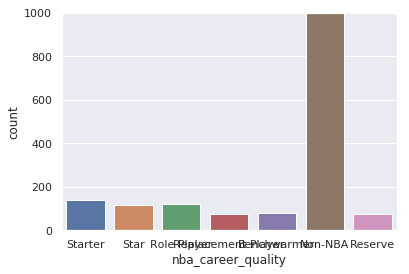

In [12]:
bar = sns.countplot(x = 'nba_career_quality', data = data)
sns.set(rc = {'figure.figsize':(12, 10)})
bar.set(ylim=(0,1000))

In [13]:
data['nba_career_quality'].value_counts()

Non-NBA               18146
Starter                 141
Role Player             121
Star                    115
Benchwarmer              80
Reserve                  77
Replacement Player       73
Name: nba_career_quality, dtype: int64

Drop the `made_nba` column as this contains actual data of who actually got drafted into the NBA. Instead our second model will rely on `nba_pred` which contains our first model's output. 

In [17]:
second_model_features = data.select_dtypes(['int', 'float']).columns.to_list()
second_model_features.remove('made_nba')
second_model_features.remove('role_numeric')

In [18]:
jb.dump(second_model_features, '../Models/second_model_inputs.pkl')

['second_model_inputs.pkl']

Our input data encompasses all of our binned features while our target variable is the NBA career success label 

In [19]:
x = np.array(data.loc[mask][second_model_features])
y = np.array(data.loc[mask].role_numeric)

This model defines a neural network that is constructed from 8 dense layers. Dense layers were chosen since we opted to utilize a non-linear activation function. Our data is not linearly separable based on our initial clustering we performed on our data in order to generate the target variable (the NBA `role` column). We iterated on the number of layers by adding more layers until the performance of the model leveled out. 

The rectified linear unit (ReLU) activation function was chosen as it was the most computationally efficient available to us. It combines the linear behavior of a linear activation function but still yields a function when derived as opposed to a constant. By having a derivative function, our model can retain the ability to perform backpropagation which allows it to optimize the weights in each neuron.

Since Tensorflow had no native gridsearch, we arrived at our model configuration using manual adjustments. We found that adding subsequent layers that operated on more condensed inputs resulted in optimal accuracy and convergence speed. 

In [20]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(data.role_numeric.nunique(), input_dim = len(second_model_features), activation = 'relu'),
        tf.keras.layers.Dense(2000, activation = 'relu'),
        tf.keras.layers.Dense(1028, activation = 'relu'),
        tf.keras.layers.Dense(512, activation = 'relu'),
        tf.keras.layers.Dense(256, activation = 'relu'),
        tf.keras.layers.Dense(128, activation = 'relu'),
        tf.keras.layers.Dense(72, activation = 'relu'),
        tf.keras.layers.Dense(data.role_numeric.nunique(), activation = 'softmax')
    ]
)

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 7)                 2828      
_________________________________________________________________
dense_1 (Dense)              (None, 2000)              16000     
_________________________________________________________________
dense_2 (Dense)              (None, 1028)              2057028   
_________________________________________________________________
dense_3 (Dense)              (None, 512)               526848    
_________________________________________________________________
dense_4 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_5 (Dense)              (None, 128)               32896     
_________________________________________________________________
dens

We iterated through several optimizer functions that would allow us to generate the best performing model. Categorical cross entropy was chosen since our model is a multi-class classification model. We are attempting to predict which class each NBA player will fit into with regards to their career outlook. Lastly, in our metrics, we wanted to capture categorical accuracy. This accuracy measures how accurate our predicted labels match the true labels. 

In [21]:
model.compile(optimizer = 'rmsprop',
              loss = 'categorical_crossentropy',
              metrics = ['categorical_accuracy'])

More than 90% of the players we look at will be labeled with Non-NBA. We want to oversample the NBA players (<10% of our dataset) to ensure that our model is able to learn patterns from the NBA players as well. 

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.5)

sm = SMOTE(random_state = 13, sampling_strategy='not majority')
x_rs, y_rs = sm.fit_resample(x, y)

y_train_one_hot = tf.keras.utils.to_categorical(y_rs, num_classes = data.role_numeric.nunique())
y_test_one_hot = tf.keras.utils.to_categorical(y_test, num_classes = data.role_numeric.nunique())

We specified batch size to be 2000 to ensure that we got enough passes through observations in our dataset to train our model. Increasing the batch size did not improve accuracy after our setpoint. We also settled on 125 to be the number of epochs as this was the number where we saw our categorical accuracy level off. 

In [23]:
model.fit(x_rs,
          y_train_one_hot,
          epochs = 125,
          batch_size = 2000)

Instructions for updating:
Use tf.cast instead.
Epoch 1/125
124257/124257 [==============================] - 31s 253us/sample - loss: 11.1481 - categorical_accuracy: 0.1642
Epoch 2/125
124257/124257 [==============================] - 30s 241us/sample - loss: 1.6924 - categorical_accuracy: 0.3261
Epoch 3/125
124257/124257 [==============================] - 32s 260us/sample - loss: 1.5067 - categorical_accuracy: 0.4028
Epoch 4/125
124257/124257 [==============================] - 35s 279us/sample - loss: 1.3737 - categorical_accuracy: 0.4600
Epoch 5/125
124257/124257 [==============================] - 32s 259us/sample - loss: 1.2834 - categorical_accuracy: 0.5032
Epoch 6/125
124257/124257 [==============================] - 31s 253us/sample - loss: 1.1911 - categorical_accuracy: 0.5392
Epoch 7/125
124257/124257 [==============================] - 34s 271us/sample - loss: 1.0986 - categorical_accuracy: 0.5787
Epoch 8/125
124257/124257 [==============================] - 34s 277us/sample - los

Overall model metrics

In [24]:
score = model.evaluate(x_test,
                       y_test_one_hot)

print(model.metrics_names)
print(score)

9179/9179 [==============================] - 1s 140us/sample - loss: 0.2605 - categorical_accuracy: 0.9417
['loss', 'categorical_accuracy']
[0.26046318148230785, 0.94171476]


Pick the most probable label based on the multi-classification and assign that label to the `predicted_role_numeric` column.

In [25]:
data['predicted_role_numeric'] = np.argmax(model.predict(np.array(data[second_model_features])), axis = 1)

Transform our numerical predictions into strings based on the `roles_dict` defined above.

In [26]:
data['predicted_role'] = [roles_dict[x] for x in [np.argmax(x) for x in model.predict_proba(np.array(data[second_model_features]))]]

In [27]:
data.head()

,ncaa_id,player_name,nba_career_quality,made_nba,field_goals_bin_1,field_goals_bin_2,field_goals_bin_3,field_goals_bin_4,three_point_attempt_rate_bin_1,three_point_attempt_rate_bin_2,three_point_attempt_rate_bin_3,defensive_win_shares_bin_1,defensive_win_shares_bin_2,defensive_win_shares_bin_3,defensive_win_shares_bin_4,blocks_bin_1,blocks_bin_2,blocks_bin_3,blocks_bin_4,blocks_bin_5,games_played_bin_1,games_played_bin_2,games_played_bin_3,turnovers_bin_1,turnovers_bin_2,turnovers_bin_3,turnovers_bin_4,turnover_percentage_bin_1,turnover_percentage_bin_2,turnover_percentage_bin_3,total_rebounds_bin_1,total_rebounds_bin_2,total_rebounds_bin_3,total_rebounds_bin_4,three_pointers_bin_1,three_pointers_bin_2,three_pointers_bin_3,three_pointers_bin_4,games_started_bin_1,games_started_bin_2,games_started_bin_3,games_started_bin_4,three_point_percentage_bin_1,three_point_percentage_bin_2,three_point_percentage_bin_3,three_point_percentage_bin_4,offensive_win_shares_bin_1,offensive_win_shares_bin_2,offensive_win_shares_bin_3,weight_bin_1,weight_bin_2,weight_bin_3,weight_bin_4,weight_bin_5,free_throw_percentage_bin_1,free_throw_percentage_bin_2,free_throw_percentage_bin_3,two_pointers_bin_1,two_pointers_bin_2,two_pointers_bin_3,two_pointers_bin_4,high_school_national_rank_bin_1,high_school_national_rank_bin_2,defensive_rebounds_bin_1,defensive_rebounds_bin_2,defensive_rebounds_bin_3,defensive_rebounds_bin_4,free_throw_attempts_bin_1,free_throw_attempts_bin_2,free_throw_attempts_bin_3,free_throw_attempts_bin_4,field_goal_percentage_bin_1,field_goal_percentage_bin_2,field_goal_percentage_bin_3,field_goal_percentage_bin_4,field_goal_percentage_bin_5,two_point_attempts_bin_1,two_point_attempts_bin_2,two_point_attempts_bin_3,two_point_attempts_bin_4,field_goal_attempts_bin_1,field_goal_attempts_bin_2,field_goal_attempts_bin_3,field_goal_attempts_bin_4,two_point_percentage_bin_1,two_point_percentage_bin_2,two_point_percentage_bin_3,two_point_percentage_bin_4,steals_bin_1,steals_bin_2,steals_bin_3,steals_bin_4,free_throw_attempt_rate_bin_1,free_throw_attempt_rate_bin_2,free_throw_attempt_rate_bin_3,free_throw_attempt_rate_bin_4,free_throw_attempt_rate_bin_5,free_throw_attempt_rate_bin_6,points_bin_1,points_bin_2,points_bin_3,points_bin_4,usage_percentage_bin_1,usage_percentage_bin_2,usage_percentage_bin_3,three_point_attempts_bin_1,three_point_attempts_bin_2,three_point_attempts_bin_3,three_point_attempts_bin_4,offensive_rebounds_bin_1,offensive_rebounds_bin_2,offensive_rebounds_bin_3,offensive_rebounds_bin_4,high_school_recruit_score_bin_2,high_school_recruit_score_bin_3,high_school_recruit_score_bin_4,high_school_recruit_score_bin_5,high_school_recruit_score_bin_6,draft_rank_bin_1,draft_rank_bin_2,draft_rank_bin_3,draft_rank_bin_4,draft_rank_bin_5,assists_bin_1,assists_bin_2,assists_bin_3,assists_bin_4,personal_fouls_bin_1,personal_fouls_bin_2,personal_fouls_bin_3,personal_fouls_bin_4,assist_percentage_bin_1,assist_percentage_bin_2,assist_percentage_bin_3,assist_percentage_bin_4,minutes_played_bin_1,minutes_played_bin_2,minutes_played_bin_3,minutes_played_bin_4,height_bin_1,height_bin_2,height_bin_3,height_bin_4,height_bin_5,made_nba_bin_1,made_nba_bin_2,height_to_weight_bin_1,height_to_weight_bin_2,height_to_weight_bin_3,height_to_weight_bin_4,height_to_weight_bin_6,weight_to_height_bin_1,weight_to_height_bin_2,weight_to_height_bin_3,weight_to_height_bin_4,weight_to_height_bin_5,weight_to_height_bin_6,recruit_draft_rank_mean_bin_1,recruit_draft_rank_mean_bin_2,draft_recruit_ratio_bin_1,draft_recruit_ratio_bin_2,draft_recruit_ratio_bin_3,draft_recruit_ratio_bin_4,assist_to_turnover_ratio_bin_1,assist_to_turnover_ratio_bin_2,assist_to_turnover_ratio_bin_3,assist_to_turnover_ratio_bin_4,assist_to_turnover_ratio_bin_5,assist_to_turnover_ratio_bin_6,assists_per_minute_bin_1,assists_per_minute_bin_2,assists_per_minute_bin_3,assists_per_minute_bin_4,assists_per_minute_bin_5,assists_per_minute_bin_6,blocks_per_minute_bin_1,blocks_per_minute_bin_2,bl

In [28]:
for i in roles_dict:
    rate = (data.loc[data.nba_career_quality == roles_dict[i]]['nba_career_quality'] == data.loc[data.nba_career_quality == roles_dict[i]]['predicted_role']).mean()
    print('{} accuracy rate: {}'.format(roles_dict[i], rate))

Benchwarmer accuracy rate: 0.8625
Non-NBA accuracy rate: 0.9443954590543371
Replacement Player accuracy rate: 0.726027397260274
Reserve accuracy rate: 0.8831168831168831
Role Player accuracy rate: 0.9008264462809917
Star accuracy rate: 0.9739130434782609
Starter accuracy rate: 0.8368794326241135


Overall career outlook prediction accuracy

In [29]:
(data.nba_career_quality == data.predicted_role).mean()

0.9420359409161201

In [30]:
model.save('../Models/active_players_career_outlook_model.h5')

Looking at our predictions for some players that we know about

In [31]:
data[data['player_name'] == 'Anthony Davis']

,ncaa_id,player_name,nba_career_quality,made_nba,field_goals_bin_1,field_goals_bin_2,field_goals_bin_3,field_goals_bin_4,three_point_attempt_rate_bin_1,three_point_attempt_rate_bin_2,three_point_attempt_rate_bin_3,defensive_win_shares_bin_1,defensive_win_shares_bin_2,defensive_win_shares_bin_3,defensive_win_shares_bin_4,blocks_bin_1,blocks_bin_2,blocks_bin_3,blocks_bin_4,blocks_bin_5,games_played_bin_1,games_played_bin_2,games_played_bin_3,turnovers_bin_1,turnovers_bin_2,turnovers_bin_3,turnovers_bin_4,turnover_percentage_bin_1,turnover_percentage_bin_2,turnover_percentage_bin_3,total_rebounds_bin_1,total_rebounds_bin_2,total_rebounds_bin_3,total_rebounds_bin_4,three_pointers_bin_1,three_pointers_bin_2,three_pointers_bin_3,three_pointers_bin_4,games_started_bin_1,games_started_bin_2,games_started_bin_3,games_started_bin_4,three_point_percentage_bin_1,three_point_percentage_bin_2,three_point_percentage_bin_3,three_point_percentage_bin_4,offensive_win_shares_bin_1,offensive_win_shares_bin_2,offensive_win_shares_bin_3,weight_bin_1,weight_bin_2,weight_bin_3,weight_bin_4,weight_bin_5,free_throw_percentage_bin_1,free_throw_percentage_bin_2,free_throw_percentage_bin_3,two_pointers_bin_1,two_pointers_bin_2,two_pointers_bin_3,two_pointers_bin_4,high_school_national_rank_bin_1,high_school_national_rank_bin_2,defensive_rebounds_bin_1,defensive_rebounds_bin_2,defensive_rebounds_bin_3,defensive_rebounds_bin_4,free_throw_attempts_bin_1,free_throw_attempts_bin_2,free_throw_attempts_bin_3,free_throw_attempts_bin_4,field_goal_percentage_bin_1,field_goal_percentage_bin_2,field_goal_percentage_bin_3,field_goal_percentage_bin_4,field_goal_percentage_bin_5,two_point_attempts_bin_1,two_point_attempts_bin_2,two_point_attempts_bin_3,two_point_attempts_bin_4,field_goal_attempts_bin_1,field_goal_attempts_bin_2,field_goal_attempts_bin_3,field_goal_attempts_bin_4,two_point_percentage_bin_1,two_point_percentage_bin_2,two_point_percentage_bin_3,two_point_percentage_bin_4,steals_bin_1,steals_bin_2,steals_bin_3,steals_bin_4,free_throw_attempt_rate_bin_1,free_throw_attempt_rate_bin_2,free_throw_attempt_rate_bin_3,free_throw_attempt_rate_bin_4,free_throw_attempt_rate_bin_5,free_throw_attempt_rate_bin_6,points_bin_1,points_bin_2,points_bin_3,points_bin_4,usage_percentage_bin_1,usage_percentage_bin_2,usage_percentage_bin_3,three_point_attempts_bin_1,three_point_attempts_bin_2,three_point_attempts_bin_3,three_point_attempts_bin_4,offensive_rebounds_bin_1,offensive_rebounds_bin_2,offensive_rebounds_bin_3,offensive_rebounds_bin_4,high_school_recruit_score_bin_2,high_school_recruit_score_bin_3,high_school_recruit_score_bin_4,high_school_recruit_score_bin_5,high_school_recruit_score_bin_6,draft_rank_bin_1,draft_rank_bin_2,draft_rank_bin_3,draft_rank_bin_4,draft_rank_bin_5,assists_bin_1,assists_bin_2,assists_bin_3,assists_bin_4,personal_fouls_bin_1,personal_fouls_bin_2,personal_fouls_bin_3,personal_fouls_bin_4,assist_percentage_bin_1,assist_percentage_bin_2,assist_percentage_bin_3,assist_percentage_bin_4,minutes_played_bin_1,minutes_played_bin_2,minutes_played_bin_3,minutes_played_bin_4,height_bin_1,height_bin_2,height_bin_3,height_bin_4,height_bin_5,made_nba_bin_1,made_nba_bin_2,height_to_weight_bin_1,height_to_weight_bin_2,height_to_weight_bin_3,height_to_weight_bin_4,height_to_weight_bin_6,weight_to_height_bin_1,weight_to_height_bin_2,weight_to_height_bin_3,weight_to_height_bin_4,weight_to_height_bin_5,weight_to_height_bin_6,recruit_draft_rank_mean_bin_1,recruit_draft_rank_mean_bin_2,draft_recruit_ratio_bin_1,draft_recruit_ratio_bin_2,draft_recruit_ratio_bin_3,draft_recruit_ratio_bin_4,assist_to_turnover_ratio_bin_1,assist_to_turnover_ratio_bin_2,assist_to_turnover_ratio_bin_3,assist_to_turnover_ratio_bin_4,assist_to_turnover_ratio_bin_5,assist_to_turnover_ratio_bin_6,assists_per_minute_bin_1,assists_per_minute_bin_2,assists_per_minute_bin_3,assists_per_minute_bin_4,assists_per_minute_bin_5,assists_per_minute_bin_6,blocks_per_minute_bin_1,blocks_per_minute_bin_2,bl